In [2]:
import numpy as np
import scipy
import pandas as pd
import math
import random
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse

In [3]:
house = pd.read_csv('/Users/nathalie.willems/Documents/AAAM/machine_learning/AI4Environment/Solar_Energy_Prediction/House_2_Processed_TimeSeries.csv')
house2 = pd.read_csv('/Users/nathalie.willems/Documents/AAAM/machine_learning/AI4Environment/Solar_Energy_Prediction/House_3_Processed_TimeSeries.csv')
house3 = pd.read_csv('/Users/nathalie.willems/Documents/AAAM/machine_learning/AI4Environment/Solar_Energy_Prediction/House_4_Processed_TimeSeries.csv')
states = pd.read_csv('/Users/nathalie.willems/Documents/AAAM/machine_learning/AI4Environment/Solar_Energy_Prediction/state_appliance_combinations.csv')
house2.head(5)

,Unnamed: 0,Time,Temperature,PV_V,Digit,Battery_V,Digit2,PV_Current,Battery_Current,PV_Power,Battery_Power,Load,Load_Corrected,Solar_Irradiance,Spillage
0,0,2015-06-23 12:28:00,30.40,18.37,32777,12.89,32779,-0.114042,-0.09240,-2.094952,-1.191036,-3.285988,0.000000,-31.480545,0.000000
1,1,2015-06-23 12:29:00,30.42,18.95,32776,12.88,32779,-0.095035,-0.09240,-1.800913,-1.190112,-2.991025,0.000000,-27.062072,0.000000
2,2,2015-06-23 12:30:00,30.43,18.79,32774,12.88,32777,-0.057021,-0.05544,-1.071425,-0.714067,-1.785492,0.000000,-16.100148,0.000000
3,3,2015-06-23 12:31:00,30.43,13.30,32760,12.80,32750,0.209077,0.44352,2.780724,5.677056,8.457780,8.457780,41.785553,8.457780
4,4,2015-06-23 12:32:00,30.42,13.23,32766,12.75,32745,0.095035,0.53592,1.257313,6.832980,8.090293,8.090293,18.893468,8.090293


In [4]:
states.head(10)

,State,Expected_Mean_Power,Appliance_Combination
0,1,0,None
1,2,9,1_CFL
2,3,14,1_Fan
3,4,18,2_CFL
4,5,23,1_Fan_1_CFL
5,6,27,3_CFL
6,7,32,2_CFL_1_Fan
7,8,36,4_CFL
8,9,41,3_CFL_1_Fan
9,10,50,4_CFL_1_Fan


In [5]:
labels = np.linspace(1,10, 10)
labels

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [6]:
def conditions(x):
    if x == 0:
        return '1'
    elif x > 0 and x <= 9:
        return '2'
    elif x > 9 and x <= 14:
        return '3'
    elif x > 14 and x <=18:
        return '4'
    elif x > 18 and x <=23:
        return '5'
    elif x > 23 and x <=27:
        return '6'
    elif x > 27 and x <=32:
        return '7'
    elif x > 32 and x <= 36:
        return '8'
    elif x > 36 and x <= 41:
        return '9'
    else:
        return '10'
    

func = np.vectorize(conditions)
energy_class = func(house['Load_Corrected'])
house['State'] = energy_class

In [7]:
house.shape

(319756, 18)

In [13]:
house['State'].value_counts().reset_index()


,index,State
0,1,193632
1,2,79220
2,4,22295
3,6,10779
4,3,7810
5,8,2856
6,5,2122
7,7,941
8,9,53
9,10,48


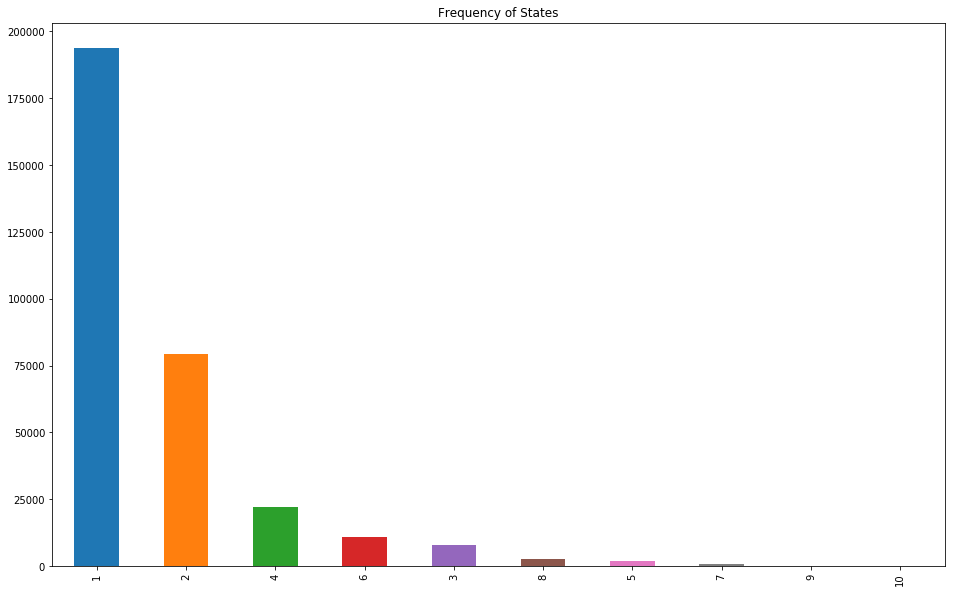

In [14]:
plt.figure(figsize=(16,10))
house['State'].value_counts().plot(kind='bar', title='Frequency of States')
plt.show()

<Figure size 1152x864 with 0 Axes>

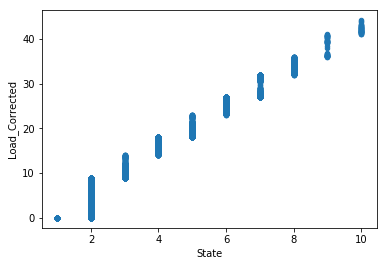

In [15]:
states_counts = house['State'].value_counts().reset_index()
columns = ['State', 'Count']
states_counts.columns = columns
states_counts = pd.DataFrame(states_counts)

plt.figure(figsize=(16,12))
#fig, ax = plt.subplots()
house['State'] = house['State'].astype('int64')
house.plot(x='State', y='Load_Corrected', kind='scatter')
#house.plot(x='State', y='Load_Corrected', kind='line', color='red', ax=ax)
plt.show()

In [16]:

states_load = house.loc[:,['State','Load_Corrected']]
states_load.loc[:,'Load_Corrected'].head(5)
X = np.array(states_load.loc[:,'Load_Corrected'])
y = np.array(states_load['State'])


In [17]:
# fit Kmeans
X = np.array(states_load.loc[:,'Load_Corrected']).reshape(-1,1)
y = np.array(states_load.loc[:,'State']).reshape(-1,1)
kmeans = KMeans(n_clusters=10)
kmeans.fit(states_load)
y_kmeans = kmeans.predict(states_load)

In [18]:
#len(y_kmeans)
centers = kmeans.cluster_centers_
labels = kmeans.labels_
len(centers)

10

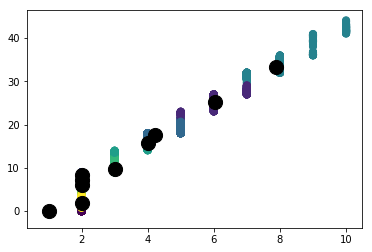

In [19]:
plt.scatter(states_load.loc[:, 'State'], states_load.loc[:, 'Load_Corrected'], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0],  centers[:, 1], c='black', s=200, alpha=1)



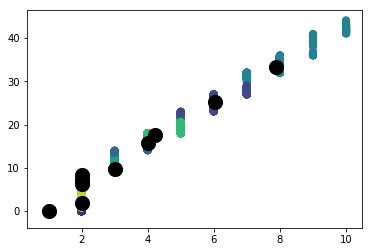

In [20]:
# fit Kmeans
X = np.array(states_load.loc[:,'Load_Corrected']).reshape(-1,1)
y = np.array(states_load.loc[:,'State']).reshape(-1,1)
kmeans = KMeans(n_clusters=10)
kmeans.fit(states_load)
y_kmeans = kmeans.predict(states_load)

plt.scatter(states_load.loc[:, 'State'], states_load.loc[:, 'Load_Corrected'], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0],  centers[:,1], c='black', s=200, alpha=1)


### State initialisation

In [21]:
## Initialise cluster centers with averages for each state

temp = states_load.groupby('State')['Load_Corrected'].mean()
temp_ar = np.array(temp)
states = [1,2,3,4,5,6,7,8,9,10]
averaged = np.column_stack((temp,states))
averaged
    

array([[ 0.        ,  1.        ],
       [ 6.71036356,  2.        ],
       [ 9.66841154,  3.        ],
       [16.29018343,  4.        ],
       [18.87594505,  5.        ],
       [25.06220111,  6.        ],
       [30.00689768,  7.        ],
       [33.32743651,  8.        ],
       [38.3894043 ,  9.        ],
       [42.15167598, 10.        ]])

/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:896: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


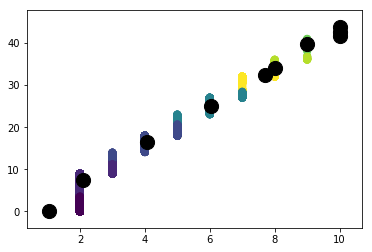

In [30]:
# fit Kmeans
X = np.array(states_load.loc[:,'Load_Corrected']).reshape(-1,1)
y = np.array(states_load.loc[:,'State']).reshape(-1,1)
kmeans = KMeans(n_clusters=10, init=averaged)
kmeans.fit(states_load)
y_kmeans = kmeans.predict(states_load)

plt.scatter(states_load.loc[:, 'State'], states_load.loc[:, 'Load_Corrected'], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0],  centers[:,1], c='black', s=200, alpha=1)

### Comparison

In [55]:
## Compare all methods

# Part 1: Quantitative evaluation of various init methods
random_state = np.random.RandomState(0)

# Number of run (with randomly generated dataset) for each strategy so as
# to be able to compute an estimate of the standard deviation
#n_runs = 5

# k-means models can do several random inits so as to be able to trade
# CPU time for convergence robustness
#n_init_range = np.array([1, 5, 10, 15, 20])
n_clusters = 10

fig = plt.figure()
plots = []
legends = []
#inertia = []

cases = [
    (KMeans, 1,'k-means++', {}),
    (KMeans,2, 'random', {}),
    (KMeans,3, averaged, {})
]
inertia = {}

for factory, i, init, params in cases:
    print("Evaluation of %s with %s init" % (factory.__name__, init))
    print(i)
    km = factory(n_clusters, init=init, **params).fit(states_load)
    if i == 3:
        init = 'averaged'
        inertia[init] = km.inertia_
    else:
        inertia[init] = km.inertia_
    print(km.inertia_)
    #centers = km.cluster_centers_

print(inertia)
#plt.scatter(inertia[i, :])
#plots.append(p[0])
#legends.append("%s with %s init" % (factory.__name__, init))

# plt.xlabel('n_init')
# plt.ylabel('inertia')
# plt.legend(plots, legends)
# plt.title("Mean inertia for various k-means init across %d runs" % n_runs)

Evaluation of KMeans with k-means++ init
1
50588.71197077208
Evaluation of KMeans with random init
2
65050.915287435964
Evaluation of KMeans with [[ 0.          1.        ]
 [ 6.71036356  2.        ]
 [ 9.66841154  3.        ]
 [16.29018343  4.        ]
 [18.87594505  5.        ]
 [25.06220111  6.        ]
 [30.00689768  7.        ]
 [33.32743651  8.        ]
 [38.3894043   9.        ]
 [42.15167598 10.        ]] init
3


/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:896: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


170470.5187938339
{'k-means++': 50588.71197077208, 'random': 65050.915287435964, 'averaged': 170470.5187938339}


<Figure size 432x288 with 0 Axes>

Text(0.5,0,'Initialisation')

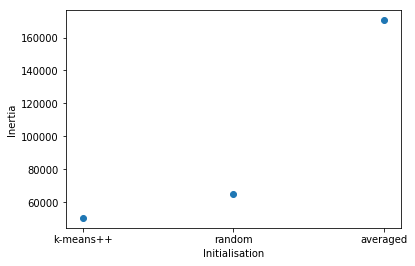

In [77]:
plt.scatter(range(len(inertia)), list(inertia.values()))
plt.xticks(range(len(inertia)), list(inertia.keys()))
plt.ylabel('Inertia')
plt.xlabel('Initialisation')

## Gaussian Mixture Models

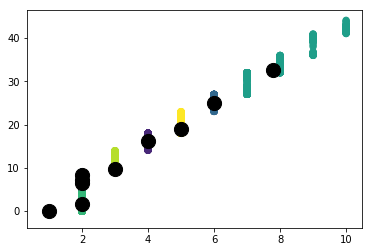

In [78]:
gmm = GaussianMixture(n_components=10).fit(states_load)
centers = gmm.means_


plt.scatter(states_load.loc[:, 'State'], states_load.loc[:, 'Load_Corrected'], c=labels, s=40, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=1)

In [73]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    #ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)
        
def plot_gmm_grid(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    #ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

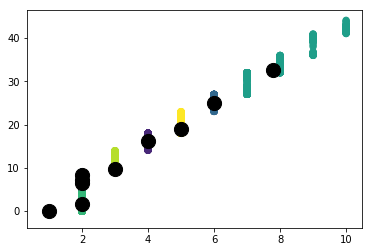

In [79]:
gmm_cov = GaussianMixture(n_components=10, covariance_type='full')
centers_cov = gmm.means_
plt.scatter(states_load.loc[:, 'State'], states_load.loc[:, 'Load_Corrected'], c=labels, s=40, cmap='viridis')
plt.scatter(centers_cov[:, 0], centers_cov[:, 1], c='black', s=200, alpha=1)

Text(0.5,0,'n_components')

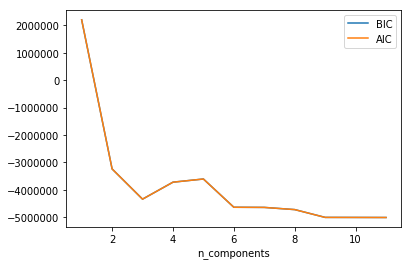

In [80]:
n_components = np.arange(1, 12)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X)
          for n in n_components]

plt.plot(n_components, [m.bic(X) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X) for m in models], label='AIC')
plt.scatter(n_components, [m.])
plt.legend(loc='best')
plt.xlabel('n_components')

### Grid-search for the optimal number of components